# DCN with TFX

***DCN TensorFlow Recommenders ranking model as a
References:***
[TFX pipeline](https://www.tensorflow.org/recommenders/examples/ranking_tfx).
[DCN](https://www.tensorflow.org/recommenders/examples/dcn)

Check the TensorFlow and TFX versions.

In [1]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

2022-07-21 20:19:31.847049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2022-07-21 20:19:31.847088: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.9.1
TFX version: 1.9.0


### Set up variables

In [2]:
import os

print(os.getcwd())
os.chdir("..")
print(os.getcwd())

PIPELINE_NAME = 'DCN-iterate'
WORKING_DIR = 'bachelor_2022/artifact'
PIPE_DIR = 'pipeline'

# Directory where MovieLens 100K rating data resides
DATA_ROOT = os.path.join('data', PIPELINE_NAME)
print(DATA_ROOT)
# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join(PIPE_DIR, 'pipelines', PIPELINE_NAME)
print(PIPELINE_ROOT)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join(PIPE_DIR, 'metadata', PIPELINE_NAME, 'metadata.db')
print(METADATA_PATH)
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join(PIPE_DIR, 'serving_model', PIPELINE_NAME)
print(SERVING_MODEL_DIR)

MODEL_PLOTS = os.path.join(PIPE_DIR, 'pipelines', PIPELINE_NAME, 'plots')
print(MODEL_PLOTS)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

/home/cory/PycharmProjects/bachelor_2022/artifact/pipeline_scripts
/home/cory/PycharmProjects/bachelor_2022/artifact
data/DCN-iterate
pipeline/pipelines/DCN-iterate
pipeline/metadata/DCN-iterate/metadata.db
pipeline/serving_model/DCN-iterate
pipeline/pipelines/DCN-iterate/plots


In [3]:
print(DATA_ROOT)

data/DCN-iterate


Take a quick look at the CSV file.

In [4]:
!head {DATA_ROOT}/ml-100k_ready.csv

head: cannot open 'data/DCN-iterate/ml-100k_colab.csv' for reading: No such file or directory


You should be able to see four values. For example, the first example means user '196' gives a rating of 3 to movie '242'.

## Create a pipeline

TFX pipelines are defined using Python APIs. We will define a pipeline which
consists of following three components.
- CsvExampleGen: Reads in data files and convert them to TFX internal format
for further processing. There are multiple
[ExampleGen](https://www.tensorflow.org/tfx/guide/examplegen)s for various
formats. In this tutorial, we will use CsvExampleGen which takes CSV file input.
- Trainer: Trains an ML model.
[Trainer component](https://www.tensorflow.org/tfx/guide/trainer) requires a
model definition code from users. You can use TensorFlow APIs to specify how to
train a model and save it in a _saved_model_ format.
- Pusher: Copies the trained model outside of the TFX pipeline.
[Pusher component](https://www.tensorflow.org/tfx/guide/pusher) can be thought
of an deployment process of the trained ML model.

Before actually define the pipeline, we need to write a model code for the
Trainer component first.

### Write model training code

We will build a simple ranking model to predict movie ratings. This model training code will be saved to a separate file.

In this tutorial we will use
[Generic Trainer](https://www.tensorflow.org/tfx/guide/trainer#generic_trainer)
of TFX which support Keras-based models. You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component.

In [5]:
_trainer_module_file = 'model_source/dcn_ranking_training.py'

The ranking model we use is almost exactly the same as in the [Basic Ranking](https://www.tensorflow.org/recommenders/examples/basic_ranking) tutorial. The only difference is that we use movie IDs instead of movie titles in the candidate tower.

In [ ]:
%%writefile {_trainer_module_file}

from typing import Dict, Text
from typing import List
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf

from tensorflow_metadata.proto.v0 import schema_pb2
import tensorflow_recommenders as tfrs
from tensorflow_transform.tf_metadata import schema_utils
from tfx import v1 as tfx
from tfx_bsl.public import tfxio

_FEATURE_KEYS = ["movie_id","user_id","user_gender", "user_occupation", "user_age_cohort"]
_LABEL_KEY = 'user_rating'

_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
        for feature in _FEATURE_KEYS
    }, _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
}

class RankingModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    # Define the dimension the features should be embedded in (Dim of vector representation of each feature)
    embedding_dimension = 32
    self.embedding_dims = embedding_dimension
    # Create np array with incrementing values as the vocabulary
    unique_user_ids = np.array(range(943)).astype(str)
    unique_movie_ids = np.array(range(1682)).astype(str)
    unique_occupation_ids = np.array(range(21)).astype(str)
    unique_gender_ids = np.array(range(2)).astype(str)
    unique_age_ids = np.array(range(7)).astype(str)


    ## String values embeddings
    # Compute embeddings for users.
    self.user_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_id', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
        # Input of 943 dims -->  Embedding of 32 dims
        tf.keras.layers.Embedding(
            len(unique_user_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for movies.
    self.movie_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='movie_id', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_movie_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_movie_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for occupations.
    self.occupation_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_occupation', dtype=tf.int64),
        tf.keras.layers.Lambda(lambda x: tf.as_string(x)),
        tf.keras.layers.StringLookup(
            vocabulary=unique_occupation_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_occupation_ids) + 1, embedding_dimension)
    ])

    ## Int value embeddings
    # Compute embeddings for gender.
    self.gender_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_gender', dtype=tf.int64),
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_gender_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_gender_ids) + 1, embedding_dimension)
    ])

    # Compute embeddings for age.
    self.age_embeddings = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,), name='user_age_cohort', dtype=tf.int64),
        tf.keras.layers.IntegerLookup(
            vocabulary=unique_age_ids, mask_token=None),
        tf.keras.layers.Embedding(
            len(unique_age_ids) + 1, embedding_dimension)
    ])

    # Cross Layer
    self.cross_layer = tfrs.layers.dcn.Cross(kernel_initializer=tf.keras.initializers.RandomNormal(seed=1)) # Use seeds to make model reproducible

    # Compute predictions.
    self.ratings = tf.keras.Sequential([
        self.cross_layer,
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1)),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(seed=1)),
        tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomNormal(seed=1))
    ])

  def call(self, inputs):

    user_id, movie_id, user_gender, user_occupation, user_age = inputs

    # Calculate embedding for each feature and save in *_embedding variable
    user_embedding = self.user_embeddings(user_id)
    movie_embedding = self.movie_embeddings(movie_id)
    gender_embedding = self.gender_embeddings(user_gender)
    occupation_embedding = self.occupation_embeddings(user_occupation)
    age_embedding = self.age_embeddings(user_age)


    # Create embedding layer
    return self.ratings(tf.concat([user_embedding, movie_embedding, gender_embedding, occupation_embedding, age_embedding], axis=2))


class MovielensModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.ranking_model: tf.keras.Model = RankingModel()
    self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

  def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
    return self.ranking_model((features['user_id'], features['movie_id'], features['user_gender'], features['user_occupation'], features['user_age_cohort']))

  def compute_loss(self,
                   features: Dict[Text, tf.Tensor],
                   training=False) -> tf.Tensor:

    labels = features[1]
    rating_predictions = self(features[0])

    # The task computes the loss and the metrics.
    return self.task(labels=labels, predictions=rating_predictions)


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 256) -> tf.data.Dataset:
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _build_keras_model() -> tf.keras.Model:
  return MovielensModel()


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # Generate training logfiles for tensorboard
  from datetime import datetime
  logdir = "pipeline/pipelines/DCN-iterate/logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

  # Derive data schema from generated _FEATURE_SPEC dictionary
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files, fn_args.data_accessor, schema, batch_size=8192)
  eval_dataset = _input_fn(
      fn_args.eval_files, fn_args.data_accessor, schema, batch_size=4096)

  model = _build_keras_model()

  model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      epochs = 1,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  model.save(fn_args.serving_model_dir)


  ###  Display model summary
  print("\n#####################################")
  print(model.summary())
  print()

  # Save plot of model architecture
  model_num = fn_args.serving_model_dir.split("/")[-2]   # extract model number
  img_dir = fn_args.custom_config["plot_path"] + f"/{model_num}"
  print(img_dir)
  Path(img_dir).mkdir(parents=True, exist_ok=True)
  tf.keras.utils.plot_model(model.ranking_model.ratings, to_file=f"{img_dir}/model_architecture_{model_num}.png", show_shapes=True)
  print()

  ### Cross feature Visualization
  mat = model.ranking_model.cross_layer._dense.kernel # Cross weights matrix
  features = _FEATURE_KEYS

  block_norm = np.ones([len(features), len(features)])
  dim = model.ranking_model.embedding_dims

  # Compute the norms of the blocks.
  for i in range(len(features)):
    for j in range(len(features)):
      # Norm of 32x32 Matrix is calculated | 32x32 values --> 1 value
      block = mat[i * dim:(i + 1) * dim,    # 32x32 blocks are retrieved from cross network
                  j * dim:(j + 1) * dim]
      block_norm[i,j] = np.linalg.norm(block, ord="fro") # Frobenius norm is used | norm of each matrix element is calculated and added together
  # Create plot
  plt.figure(figsize=(9,9))
  im = plt.matshow(block_norm, cmap=plt.cm.Blues)
  ax = plt.gca()
  divider = make_axes_locatable(plt.gca())
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im, cax=cax)
  cax.tick_params(labelsize=10)
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
  _ = ax.set_yticklabels([""] + features, fontsize=10)

  plt.savefig(f"{img_dir}/cross_features_{model_num}", dpi=500, bbox_inches='tight')

Now you have completed all preparation steps to build the TFX pipeline.

### Write a pipeline definition

We define a function to create a TFX pipeline. A `Pipeline` object
represents a TFX pipeline which can be run using one of pipeline
orchestration systems that TFX supports.


In [32]:
import tensorflow_model_analysis as tfma
from google.protobuf import text_format

def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str, plot_path: str) -> tfx.dsl.Pipeline:
  """Creates a three component pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Evaluate rudimentary statistics on the dataset
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples']
      )

  # Read and infer schema of the dataset
  schema_gen = tfx.components.SchemaGen(
    statistics=statistics_gen.outputs['statistics']
  )

  # Check dataset for anomalies
  example_validator = tfx.components.ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema'])

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=12),
      eval_args=tfx.proto.EvalArgs(num_steps=24),
      custom_config={"plot_path": plot_path})


  # Evaluation of trained model against deployed models

  model_resolver = tfx.dsl.Resolver(
        strategy_class=tfx.dsl.experimental.LatestBlessedModelStrategy,
        model=tfx.dsl.Channel(type=tfx.types.standard_artifacts.Model),
        model_blessing=tfx.dsl.Channel(
            type=tfx.types.standard_artifacts.ModelBlessing)).with_id(
                'latest_blessed_model_resolver')

  eval_config = tfma.EvalConfig(
      model_specs=[tfma.ModelSpec(label_key="user_rating")],
      slicing_specs=[tfma.SlicingSpec()],
      metrics_specs = [
          tfma.MetricsSpec(metrics=[
              tfma.MetricConfig(class_name="ExampleCount"),
              tfma.MetricConfig(class_name="MeanSquaredError"),
              tfma.MetricConfig(class_name="BinaryAccuracy",
                   threshold=tfma.MetricThreshold(
                       value_threshold=tfma.GenericValueThreshold(
                           lower_bound={"value":0.1}),
                       change_threshold=tfma.GenericChangeThreshold(
                           direction=tfma.MetricDirection.HIGHER_IS_BETTER,
                           absolute={"value":0.001})
                   ))

          ])
          ]
      )

  evaluator = tfx.components.Evaluator(
      examples=example_gen.outputs['examples'],
      model=trainer.outputs['model'],
      baseline_model=model_resolver.outputs['model'],
      eval_config=eval_config)

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      example_validator,
      trainer,
      # model_resolver,
      # evaluator,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

## Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.

Now we create a `LocalDagRunner` and pass a `Pipeline` object created from the
function we already defined.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Excluding no splits because exclude_splits is not set.
INFO:absl:Generating ephemeral wheel package for '/home/cory/PycharmProjects/bachelor_2022/artifact/model_source/dcn_ranking_training.py' (including modules: ['dcn_ranking_training', 'dcn_ranking_training_test', 'tfx_tfrs_training']).
INFO:absl:User module package has hash fingerprint version 41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252.
INFO:absl:Executing: ['/home/cory/anaconda3/envs/bachelor_2022/bin/python', '/tmp/tmphpkr2hxo/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpgs10y_d0', '--dist-dir', '/tmp/tmpc3bppdwy']


running bdist_wheel
running build
running build_py
creating build
creating build/lib
copying dcn_ranking_training.py -> build/lib
copying dcn_ranking_training_test.py -> build/lib
copying tfx_tfrs_training.py -> build/lib
installing to /tmp/tmpgs10y_d0
running install
running install_lib
copying build/lib/tfx_tfrs_training.py -> /tmp/tmpgs10y_d0
copying build/lib/dcn_ranking_training_test.py -> /tmp/tmpgs10y_d0
copying build/lib/dcn_ranking_training.py -> /tmp/tmpgs10y_d0
running install_egg_info
running egg_info
creating tfx_user_code_Trainer.egg-info
writing tfx_user_code_Trainer.egg-info/PKG-INFO
writing dependency_links to tfx_user_code_Trainer.egg-info/dependency_links.txt


/home/cory/anaconda3/envs/bachelor_2022/lib/python3.8/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
INFO:absl:Successfully built user code wheel distribution at 'pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3-none-any.whl'; target user module is 'dcn_ranking_training'.
INFO:absl:Full user module path is 'dcn_ranking_training@pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3-none-any.whl'
INFO:absl:Using deployment config:
 executor_specs {
  key: "CsvExampleGen"
  value {
    beam_executable_spec {
      python_executor_spec {
        class_path: "tfx.components.example_gen.csv_example_gen.executor.Executor"
      }
    }
  }
}
executor_specs {
  key: "ExampleValidator"
  value {
    pyth

writing top-level names to tfx_user_code_Trainer.egg-info/top_level.txt
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
reading manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
writing manifest file 'tfx_user_code_Trainer.egg-info/SOURCES.txt'
Copying tfx_user_code_Trainer.egg-info to /tmp/tmpgs10y_d0/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3.8.egg-info
running install_scripts
creating /tmp/tmpgs10y_d0/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252.dist-info/WHEEL
creating '/tmp/tmpc3bppdwy/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3-none-any.whl' and adding '/tmp/tmpgs10y_d0' to it
adding 'dcn_ranking_training.py'
adding 'dcn_ranking_training_test.py'
adding 'tfx_tfrs_training.py'
adding 'tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252.dist-info/METADATA'
adding 'tfx_u

INFO:absl:select span and version = (0, None)
INFO:absl:latest span and version = (0, None)
INFO:absl:MetadataStore with DB connection initialized
INFO:absl:Going to run a new execution 221
INFO:absl:Going to run a new execution: ExecutionInfo(execution_id=221, input_dict={}, output_dict=defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "pipeline/pipelines/DCN-iterate/CsvExampleGen/examples/221"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:1,total_bytes:2617288,xor_checksum:1658143009,sum_checksum:1658143009"
  }
}
custom_properties {
  key: "name"
  value {
    string_value: "DCN-iterate:2022-07-22T00:55:22.845175:CsvExampleGen:examples:0"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
name: "DCN-iterate:2022-07-22T00:55:22.845175:CsvExampleGen:examples:0"
, artifact_type: name: "Examples"
properties {
  key: "span"
  value: INT
}
properties {
  key: "split_names"
  value: STRING
}
pr

Processing ./pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3-none-any.whl


INFO:absl:Successfully installed 'pipeline/pipelines/DCN-iterate/_wheels/tfx_user_code_Trainer-0.0+41e97e6838c46fc841fb6fcf3cb2046c9780bc0863043718fd16de9c3ef39252-py3-none-any.whl'.
INFO:absl:Training model.
INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_occupation has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_rating has a shape dim {
  size: 1
}
. Setting to DenseTensor.


INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_occupation has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_rating has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature movie_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_age_cohort has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_gender has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_id has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_occupation has a shape dim {
  size: 1
}
. Setting to DenseTensor.
INFO:absl:Feature user_rating has a shape dim {
  si

12/12 [==============================] - 3s 151ms/step - root_mean_squared_error: 2.4957 - loss: 5.8442 - regularization_loss: 0.0000e+00 - total_loss: 5.8442 - val_root_mean_squared_error: 1.1294 - val_loss: 1.4045 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.4045


INFO:tensorflow:Assets written to: pipeline/pipelines/DCN-iterate/Trainer/model/223/Format-Serving/assets


INFO:tensorflow:Assets written to: pipeline/pipelines/DCN-iterate/Trainer/model/223/Format-Serving/assets



#####################################
Model: "movielens_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ranking_model_10 (RankingMo  multiple                 168609    
 del)                                                            
                                                                 
 ranking_10 (Ranking)        multiple                  0         
                                                                 
Total params: 168,609
Trainable params: 168,609
Non-trainable params: 0
_________________________________________________________________
None

pipeline/pipelines/DCN-iterate/plots/223


E0722 00:56:08.791733853     687 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0722 00:56:08.970652623     687 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


/tmp/tmpj4bp2bee/dcn_ranking_training.py:231: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/tmp/tmpj4bp2bee/dcn_ranking_training.py:232: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)
INFO:absl:Training complete. Model written to pipeline/pipelines/DCN-iterate/Trainer/model/223/Format-Serving. ModelRun written to pipeline/pipelines/DCN-iterate/Trainer/model_run/223
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 223 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'model_run': [Artifact(artifact: uri: "pipeline/pipelines/DCN-iterate/Trainer/model_run/223"
custom_properties {
  key: "name"
  value {
    string_value: "DCN-iterate:2022-07-22T00:55:22.845175:Trainer:model_run:0"
  }
}
custom_properties {
 

<Figure size 648x648 with 0 Axes>

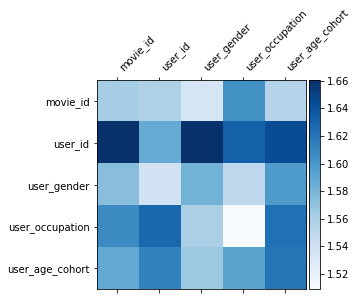

In [33]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      data_root=DATA_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH,
      plot_path=MODEL_PLOTS))

In [9]:
# List files in created model directory.
!ls -R {SERVING_MODEL_DIR}

pipeline/serving_model/DCN-iterate:
1658143931  1658241672	1658246554  1658264266	1658270183  1658276127
1658156250  1658241808	1658247040  1658264498	1658270309  1658278666
1658156418  1658242623	1658247911  1658264743	1658270419  1658358720
1658156805  1658243152	1658261251  1658265853	1658272648  1658427634
1658162917  1658244105	1658263017  1658266121	1658272757
1658163244  1658244394	1658263703  1658266549	1658275631
1658163413  1658244568	1658263766  1658270110	1658276011

pipeline/serving_model/DCN-iterate/1658143931:
assets	keras_metadata.pb  saved_model.pb  variables

pipeline/serving_model/DCN-iterate/1658143931/assets:

pipeline/serving_model/DCN-iterate/1658143931/variables:
variables.data-00000-of-00001  variables.index

pipeline/serving_model/DCN-iterate/1658156250:
assets	keras_metadata.pb  saved_model.pb  variables

pipeline/serving_model/DCN-iterate/1658156250/assets:

pipeline/serving_model/DCN-iterate/1658156250/variables:
variables.data-00000-of-00001  variables.ind

Now we can test the ranking model by computing predictions for a user and a movie:

In [10]:
import glob
# Load the latest model for testing
loaded = tf.saved_model.load(max(glob.glob(os.path.join(SERVING_MODEL_DIR, '*/')), key=os.path.getmtime))
print(loaded({'user_id': [[42]], 'movie_id': [[15]], 'user_gender': [[1]], 'user_occupation': [[0]], 'user_age_cohort': [[0]]}).numpy())

[[[3.056094]]]
